## In this notebook, we will
1. Create feed forward NN 
2. Tune the batch size for our NN model

From  <font color='blue'>1.MolRedPot_NN_LearningRateTuning.ipynb</font>, the tuned value of the learning rate is 1e-3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from decimal import Decimal
import time as time
import seaborn as sns

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.backend import clear_session

## Import training data and split into training+validation sets
Data was previously split into training and testing sets in <font color='blue'>../1.MolRedPot_FeatureEngineering.ipynb</font>

In [15]:
features=pd.read_csv('Data/features_train_scaled.csv')
target=pd.read_csv('Data/target_train.csv')['ERed']

In [16]:
print('Feature matrix shape: ',features.shape)
print('Target property shape: ',target.shape)

Feature matrix shape:  (4353, 32)
Target property shape:  (4353,)


In [17]:
features_train,features_val,target_train,target_val=train_test_split(features,target,test_size=0.2,random_state=15)

In [18]:
features_train=tf.convert_to_tensor(features_train,dtype=tf.float64)
target_train=tf.convert_to_tensor(target_train,dtype=tf.float64)
features_val=tf.convert_to_tensor(features_val,dtype=tf.float64)
target_val=tf.convert_to_tensor(target_val,dtype=tf.float64)

## Define dictionary; which will store the NN performance metrics for varying learning rates

In [19]:
bs_grid={}

Create NN architecture

In [27]:
def nn_arch():
    
    num_dens_layers=4     
    n_nodes=[64, 32,16, 1]
    learning_rate=1e-3

    model = Sequential()
    model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
    
    for i in range(1,num_dens_layers):
        model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    
    
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=1e-3), metrics=['mean_absolute_error'])
    
    return model

Create function to train NN model for a particular learning rate and save performance metrics

In [28]:
def bs_tuning(bs):
    
    clear_session()
    
    t1=time.time()
    
    model=nn_arch()
    
    history=model.fit(features_train, target_train, 
                      epochs=50, batch_size=bs, 
                      validation_data = (features_val, target_val), verbose=0)
    t2=time.time()
    
    training_loss=(history.history['mean_absolute_error'])
    validation_loss=(history.history['val_mean_absolute_error'])
    
    train_nn=model.predict(features_train)
    val_nn=model.predict(features_val)
    training_r2=r2_score(target_train,train_nn)
    validation_r2=r2_score(target_val,val_nn)
    
    temp={}
    temp['Training_loss']=training_loss
    temp['Validation_loss']=validation_loss
    temp['Training_r2']=training_r2
    temp['Validation_r2']=validation_r2
    temp['Training_time']=t2-t1
    
    bs_grid[str(bs)]=temp
    
    print('batch size = ',bs,'training time = ',t2-t1,' s')
    
    clear_session()

In [29]:
batch_sizes=[16,32,64,128,256,512]
for bs in batch_sizes:
    bs_tuning(bs)

28/28 [==============================] - 0s 844us/step
batch size =  16 training time =  16.534836530685425  s
28/28 [==============================] - 0s 905us/step
batch size =  32 training time =  9.177834272384644  s
28/28 [==============================] - 0s 828us/step
batch size =  64 training time =  5.61537766456604  s
28/28 [==============================] - 0s 959us/step
batch size =  128 training time =  4.088072061538696  s
28/28 [==============================] - 0s 850us/step
batch size =  256 training time =  2.9682326316833496  s
28/28 [==============================] - 0s 939us/step
batch size =  512 training time =  2.6528160572052  s


## Plotting 'training loss vs epochs' for different batch sizes

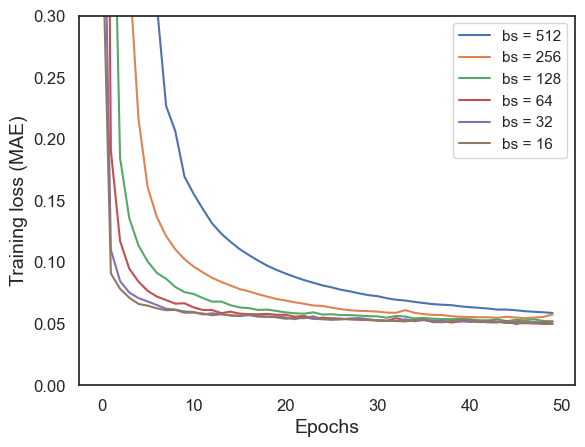

In [30]:
for k in list(bs_grid.keys())[::-1]:
    plt.plot(bs_grid[k]['Training_loss'],label='bs = '+str(k))
    plt.ylim([0,0.3])
plt.xlabel('Epochs',fontsize=14)    
plt.xticks(fontsize=12)
plt.ylabel('Training loss (MAE)',fontsize=14)    
plt.yticks(fontsize=12)
plt.legend()
plt.show()

## Plotting 'training & validation losses vs epochs' for different batch sizes

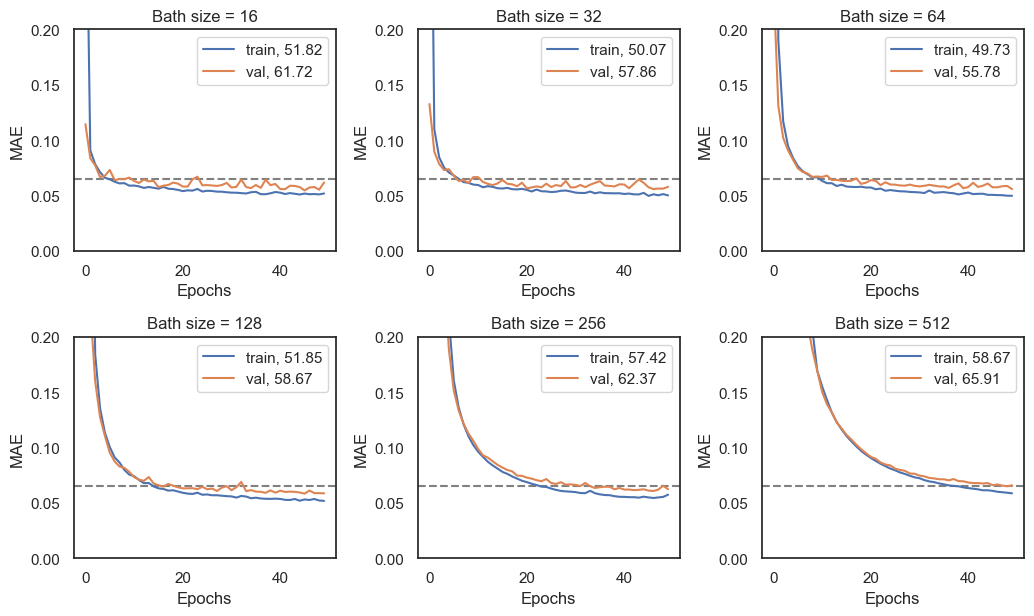

In [31]:
keys=list(bs_grid.keys())
nr_rows = 4
nr_cols = 3
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3),sharex=False)

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(bs_grid):

            # axs[r][c].set_title(f"{keys[i]} = {learning_rates[i]}, {min(y):0.2f}")
            y=bs_grid[keys[i]]["Training_loss"]
            axs[r][c].axhline(0.065,ls='--',c='gray')
            axs[r][c].set_title(f"Bath size = {keys[i]}")
            axs[r][c].plot(np.arange(len(y)),y,label=f"train, {y[-1]*1000:0.2f}")
            y=bs_grid[keys[i]]["Validation_loss"]
            axs[r][c].plot(np.arange(len(y)),y,label=f"val, {y[-1]*1000:0.2f}")
            axs[r][c].legend()
            axs[r][c].set_xlabel("Epochs")
            axs[r][c].set_ylabel("MAE")
            axs[r][c].set_ylim(0,0.2)
            # axs[r][c].text(f"{y.min():0.2f}")

        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
plt.show()  

## Comparing training MAE and validation MAE for different batch sizes

In [32]:
train_mae=[bs_grid[k]['Training_loss'][-1] for k in list(bs_grid.keys())]
val_mae=[bs_grid[k]['Validation_loss'][-1] for k in list(bs_grid.keys())]

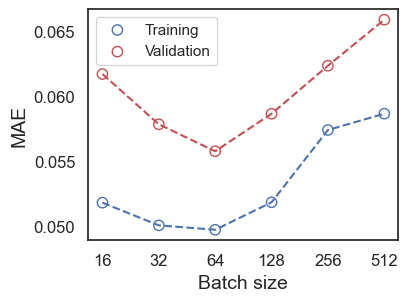

In [33]:
plt.figure(figsize=(4,3))
plt.scatter(range(len(batch_sizes)),train_mae,c='b',label='Training',s=55,fc='none', ec='b')
plt.plot(range(len(batch_sizes)),train_mae,c='b',ls='--')
plt.scatter(range(len(batch_sizes)),val_mae,c='b',label='Validation',s=55,fc='none', ec='r')
plt.plot(range(len(batch_sizes)),val_mae,c='r',ls='--')
plt.xlabel('Batch size',fontsize=14)    
plt.xticks(range(len(batch_sizes)),batch_sizes,fontsize=12)
plt.ylabel('MAE',fontsize=14)    
plt.yticks(fontsize=12)
plt.legend()
plt.show()

## Comparing training times

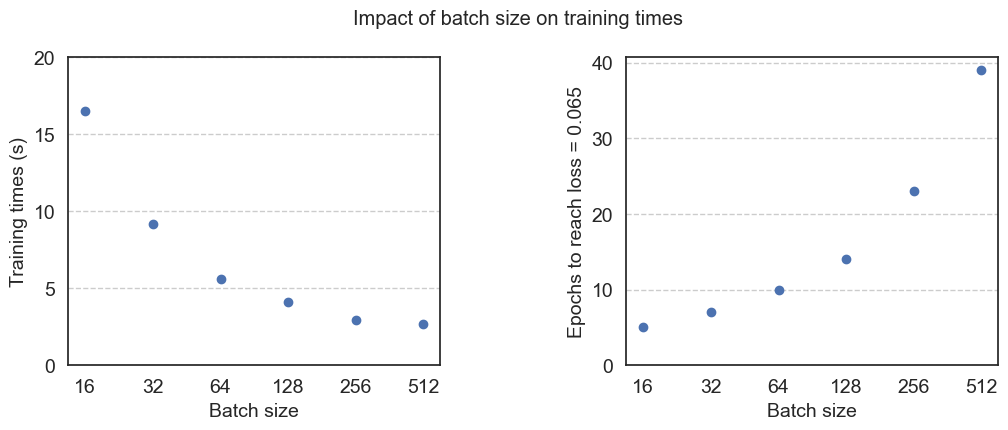

In [35]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))
plt.subplots_adjust(wspace=0.5)

fig.suptitle('Impact of batch size on training times',y=1)

ax[0].scatter(range(len(batch_sizes)),[bs_grid[k]['Training_time'] for k in bs_grid.keys()])
ax[0].set_xticks(range(len(batch_sizes)),batch_sizes,fontsize=14)
ax[0].set_xlabel('Batch size',fontsize=14)
ax[0].set_ylabel('Training times (s)',fontsize=14)
ax[0].set_yticks(range(0,25,5),range(0,25,5),fontsize=14)
ax[0].grid(axis='y',ls='--')

ax[1].scatter(range(len(batch_sizes)),[np.where(np.array(bs_grid[str(k)]['Training_loss'])<0.065)[0][0] for k in batch_sizes])
ax[1].set_ylabel('Epochs to reach loss = 0.065',fontsize=14)
ax[1].set_xlabel('Batch size',fontsize=14)
ax[1].set_xticks(range(len(batch_sizes)),batch_sizes,fontsize=14)
ax[1].set_yticks(range(0,50,10),range(0,50,10),fontsize=14)
ax[1].grid(axis='y',ls='--')

plt.show()

<b>Larger batch sizes</b> result in faster training times, for the same number of epochs. However, the training and validation errors are larger since the model weights are updated less frequently. 

1. They consume more memory compared to training using smaller batch sizes.

2. They have smaller fluctuations in MAE since weights are updated less frequently. For example, the MAE vs epochs profile for bs = 512 is much smoother as compared to bs = 64.

2. However, larger number of epochs are required to reach the same training MAE loss. For bs = 512, the MAE loss < 0.065 after 45 epochs. In contrast, for bs = 64, MAE loss < 0.065 after 11 epochs.

## <font color='blue'>The tuned value of the batch size is 64</font>

In the next notebook, <font color = blue>3d.MolRedPot_NN_tuned.ipynb
</font>, we will use a feed forward NN with the tuned hyperparameters to predict the reduction potential.